In [1]:
!pip install python-chess numpy numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148498 sha256=734b829c5d50753aa36898b4ca65bd05d776ad401d641033cd7dc3805e1aa23c
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [2]:
import requests
requests.get('http://www.google.com',timeout=10).ok


True

In [3]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments

In [4]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)

No pygame installed, ignoring import



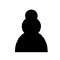
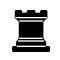
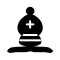
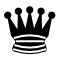
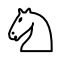
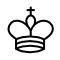
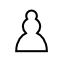
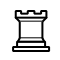
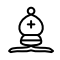
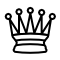
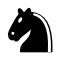
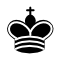

In [5]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

 Chess bot
    - RAM: 5MB max
    - CPU: Single 2.20GHz core
    - Tamaño: <64KB comprimido
    - Tiempo: 0.1s simple delay
    - RAM total controlada: ~4.8MB
    - Valores y tablas compactas (~800KB total)
    - PST minimalistas pero efectivas

https://www.chessprogramming.org/Simplified_Evaluation_Function

In [6]:
%%writefile main.py
import time
import random
from Chessnut import Game

# Piece values
PIECE_VALUES = {'P': 100, 'N': 320, 'B': 330, 'R': 500, 'Q': 900, 'K': 20000}

# Piece-square tables for positional evaluation
PIECE_SQUARE_TABLES = {
    'P': [
        # Pawn
         0,   0,   0,   0,   0,   0,   0,   0,
        50,  50,  50,  50,  50,  50,  50,  50,
        10,  10,  20,  30,  30,  20,  10,  10,
         5,   5,  10,  25,  25,  10,   5,   5,
         0,   0,   0,  20,  20,   0,   0,   0,
         5,  -5, -10,   0,   0, -10,  -5,   5,
         5,  10,  10, -20, -20,  10,  10,   5,
         0,   0,   0,   0,   0,   0,   0,   0
    ],
    'N': [
        # Knight
        -50, -40, -30, -30, -30, -30, -40, -50,
        -40, -20,   0,   0,   0,   0, -20, -40,
        -30,   0,  10,  15,  15,  10,   0, -30,
        -30,   5,  15,  20,  20,  15,   5, -30,
        -30,   0,  15,  20,  20,  15,   0, -30,
        -30,   5,  10,  15,  15,  10,   5, -30,
        -40, -20,   0,   5,   5,   0, -20, -40,
        -50, -40, -30, -30, -30, -30, -40, -50
    ],
    'B': [
        # Bishop
        -20, -10, -10, -10, -10, -10, -10, -20,
        -10,   0,   0,   0,   0,   0,   0, -10,
        -10,   0,   5,  10,  10,   5,   0, -10,
        -10,   5,   5,  10,  10,   5,   5, -10,
        -10,   0,  10,  10,  10,  10,   0, -10,
        -10,  10,  10,  10,  10,  10,  10, -10,
        -10,   5,   0,   0,   0,   0,   5, -10,
        -20, -10, -10, -10, -10, -10, -10, -20
    ],
    'R': [
        # Rook
          0,   0,   0,   0,   0,   0,   0,   0,
          5,  10,  10,  10,  10,  10,  10,   5,
         -5,   0,   0,   0,   0,   0,   0,  -5,
         -5,   0,   0,   0,   0,   0,   0,  -5,
         -5,   0,   0,   0,   0,   0,   0,  -5,
         -5,   0,   0,   0,   0,   0,   0,  -5,
         -5,   0,   0,   0,   0,   0,   0,  -5,
          0,   0,   0,   5,   5,   0,   0,   0
    ],
    'Q': [
        # Queen
        -20, -10, -10,  -5,  -5, -10, -10, -20,
        -10,   0,   0,   0,   0,   0,   0, -10,
        -10,   0,   5,   5,   5,   5,   0, -10,
         -5,   0,   5,   5,   5,   5,   0,  -5,
          0,   0,   5,   5,   5,   5,   0,  -5,
        -10,   5,   5,   5,   5,   5,   0, -10,
        -10,   0,   5,   0,   0,   0,   0, -10,
        -20, -10, -10,  -5,  -5, -10, -10, -20
    ],
    'K_MIDDLE': [
        # King middle game
        -30, -40, -40, -50, -50, -40, -40, -30,
        -30, -40, -40, -50, -50, -40, -40, -30,
        -30, -40, -40, -50, -50, -40, -40, -30,
        -30, -40, -40, -50, -50, -40, -40, -30,
        -20, -30, -30, -40, -40, -30, -30, -20,
        -10, -20, -20, -20, -20, -20, -20, -10,
         20,  20,   0,   0,   0,   0,  20,  20,
         20,  30,  10,   0,   0,  10,  30,  20
    ],
    'K_END': [
        # King end game
        -50, -40, -30, -20, -20, -30, -40, -50,
        -30, -20, -10,   0,   0, -10, -20, -30,
        -30, -10,  20,  30,  30,  20, -10, -30,
        -30, -10,  30,  40,  40,  30, -10, -30,
        -30, -10,  30,  40,  40,  30, -10, -30,
        -30, -10,  20,  30,  30,  20, -10, -30,
        -30, -30,   0,   0,   0,   0, -30, -30,
        -50, -30, -30, -30, -30, -30, -30, -50
    ]
}

def square_index(square):
    file = ord(square[0]) - ord('a')
    rank = int(square[1]) - 1
    return rank * 8 + file

def is_endgame(game):
    white_material = 0
    black_material = 0
    white_queen = 0
    black_queen = 0
    white_minor = 0
    black_minor = 0
    
    board_str = str(game.board)  # Convertimos el tablero a string
    for square in range(64):
        piece = board_str[square]
        if piece != ' ':
            if piece.isupper():
                value = PIECE_VALUES.get(piece.upper(), 0)
                white_material += value
                if piece.upper() == 'Q':
                    white_queen += 1
                elif piece.upper() in ['N', 'B']:
                    white_minor += 1
            else:
                value = PIECE_VALUES.get(piece.upper(), 0)
                black_material += value
                if piece.upper() == 'Q':
                    black_queen += 1
                elif piece.upper() in ['N', 'B']:
                    black_minor += 1
    
    return (white_queen == 0 and black_queen == 0) or \
           ((white_queen == 0 or (white_queen == 1 and white_minor <= 1)) and \
            (black_queen == 0 or (black_queen == 1 and black_minor <= 1)))

def evaluate_position(game):
    score = 0
    endgame = is_endgame(game)
    
    board_str = str(game.board)
    for square in range(64):
        piece = board_str[square]
        if piece != ' ':
            value = PIECE_VALUES.get(piece.upper(), 0)
            score += value if piece.isupper() else -value
            
            piece_type = piece.upper()
            if piece_type == 'K':
                if endgame:
                    pst = PIECE_SQUARE_TABLES['K_END']
                else:
                    pst = PIECE_SQUARE_TABLES['K_MIDDLE']
            else:
                pst = PIECE_SQUARE_TABLES.get(piece_type, None)
                
            if pst:
                score += pst[square] if piece.isupper() else -pst[63 - square]
    
    return score

def make_move(move, time_to_start_thinking):
    return move

def is_capture(game, move):
    to_square = Game.xy2i(move[2:4])
    board_str = str(game.board)
    return board_str[to_square] != ' '

def get_piece_value(piece):
    return PIECE_VALUES[piece.upper()] if piece.isalpha() else 0

def move_priority(game, move):
    if is_capture(game, move):
        from_square = Game.xy2i(move[:2])
        to_square = Game.xy2i(move[2:4])
        board_str = str(game.board)
        attacker = board_str[from_square]
        victim = board_str[to_square]
        if attacker != ' ' and victim != ' ':
            attacker_value = get_piece_value(attacker)
            victim_value = get_piece_value(victim)
            return victim_value - attacker_value
    return 0

def generate_ordered_moves(game):
    moves = list(game.get_moves())
    moves.sort(key=lambda move: move_priority(game, move), reverse=True)
    return moves

# Transposition table
MAX_TABLE_SIZE = 10000
transposition_table = {}

def alpha_beta(game, depth, alpha, beta, color, time_start, time_limit):
    if time.time() - time_start >= time_limit:
        return None, color * evaluate_position(game)
    
    board_key = game.get_fen()
    if board_key in transposition_table:
        return None, transposition_table[board_key]
    
    if depth == 0:
        eval_score = quiescence_search(game, alpha, beta, color, time_start, time_limit)
        if len(transposition_table) < MAX_TABLE_SIZE:
            transposition_table[board_key] = eval_score
        return None, eval_score
    
    best_move = None
    max_eval = float('-inf')
    
    for move in generate_ordered_moves(game):
        if time.time() - time_start >= time_limit:
            break
        
        game.apply_move(move)
        _, eval = alpha_beta(game, depth - 1, -beta, -alpha, -color, time_start, time_limit)
        game.undo_move()
        
        eval = -eval
        if eval > max_eval:
            max_eval = eval
            best_move = move
            
        alpha = max(alpha, eval)
        if alpha >= beta:
            break
            
    if len(transposition_table) < MAX_TABLE_SIZE:
        transposition_table[board_key] = max_eval
        
    return best_move, max_eval

def quiescence_search(game, alpha, beta, color, time_start, time_limit):
    if time.time() - time_start >= time_limit:
        return color * evaluate_position(game)
        
    stand_pat = color * evaluate_position(game)
    if stand_pat >= beta:
        return beta
    if alpha < stand_pat:
        alpha = stand_pat
        
    for move in generate_ordered_moves(game):
        if not is_capture(game, move):
            continue
            
        game.apply_move(move)
        eval = -quiescence_search(game, -beta, -alpha, -color, time_start, time_limit)
        game.undo_move()
        
        if eval >= beta:
            return beta
        if eval > alpha:
            alpha = eval
            
    return alpha

def mate_search(game, depth, time_start, time_limit):
    if time.time() - time_start >= time_limit:
        return None, 0
    if depth == 0:
        # Mejor manejo del estado del juego
        try:
            if game.status == Game.CHECKMATE:  # Comparación específica con la constante
                return None, 100000
        except AttributeError:
            pass  # En caso de que status no esté disponible
        return None, 0
        
    best_move = None
    for move in generate_ordered_moves(game):
        try:
            game.apply_move(move)
            _, score = mate_search(game, depth - 1, time_start, time_limit)
            game.undo_move()
        except Exception:
            continue  # Si hay algún error con el movimiento, continuamos
            
        if score == 100000:
            return move, score
            
        if time.time() - time_start >= time_limit:
            break
            
    return None, 0

def chess_bot(obs):
    time_start = time.time()
    time_limit = 0.09  # Maximum time per move
    
    try:
        game = Game(obs.board)
        moves = list(game.get_moves())
    except Exception as e:
        print(f"Error initializing game: {e}")
        return ""
    
    if not moves:
        return ""
    
    # Apertura más robusta
    if obs.mark == 'white' and obs.step == 0:
        if 'e2e4' in moves:
            return make_move('e2e4', time_start)
        elif 'd2d4' in moves:  # Alternativa si e2e4 no está disponible
            return make_move('d2d4', time_start)
    
    # Control de tiempo más preciso
    time_used = time.time() - time_start
    if time_used > time_limit * 0.1:  # Si ya usamos más del 10% del tiempo
        time_limit = time_limit * 0.9  # Reducimos el límite
    
    # Búsqueda de mate con control de errores
    try:
        for depth in range(1, 4):
            if time.time() - time_start >= time_limit:
                break
            move, score = mate_search(game, depth, time_start, time_limit)
            if move:
                return make_move(move, time_start)
    except Exception as e:
        print(f"Error in mate search: {e}")
    
    # Iterative deepening con mejor control de errores
    best_move = moves[0]
    depth = 1
    while depth <= 5:  # MAX_DEPTH = 5
        if time.time() - time_start >= time_limit:
            break
        try:
            move, _ = alpha_beta(game, depth, float('-inf'), float('inf'), 1, time_start, time_limit)
            if move:
                best_move = move
        except Exception as e:
            print(f"Error in alpha-beta search at depth {depth}: {e}")
            break
        depth += 1
    
    return make_move(best_move, time_start)

Writing main.py


Error in mate search: string index out of range
Error in alpha-beta search at depth 1: string index out of range
Error in mate search: string index out of range
Error in alpha-beta search at depth 1: string index out of range
Error in mate search: string index out of range
Error in alpha-beta search at depth 1: string index out of range
Error in mate search: string index out of range
Error in alpha-beta search at depth 1: string index out of range
Error in mate search: string index out of range
Error in alpha-beta search at depth 1: string index out of range
Error in mate search: string index out of range
Error in alpha-beta search at depth 1: string index out of range
Error in mate search: string index out of range
Error in alpha-beta search at depth 1: string index out of range
Error in mate search: string index out of range
Error in alpha-beta search at depth 1: string index out of range
Error in mate search: string index out of range
Error in alpha-beta search at depth 1: string in


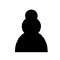
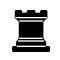
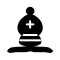
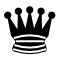
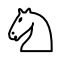
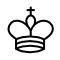
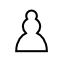
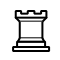
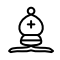
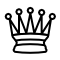
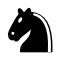
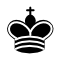

In [7]:
result = env.run(["main.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=500, height=500) 